In [1]:
# Importing libraries
import os
import numpy as np
from pylab import imread
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

In [2]:
#GPU check
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Unziping data
# import zipfile
# with zipfile.ZipFile(os.getcwd()+'\img_align_celeba.zip', 'r') as zip_ref:
#     zip_ref.extractall('celaba_data')

In [5]:
# Loading data and reshaping to (28,28)
image_size=(28, 28)
data_dir = os.getcwd()+'\celaba_data'
train_ds = keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=42,
  image_size=image_size,
  color_mode='rgb',batch_size=10000)

Found 202599 files belonging to 1 classes.


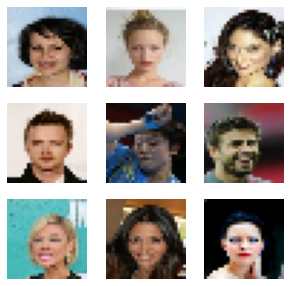

In [6]:
# Viewing data
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
# defining gen, disc. ,loss

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 3]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
# Data prep.

for images, labels in train_ds.take(1):
    images=images

X_train = images.numpy().astype("uint8").reshape(-1, 28, 28, 3) / 127.5 - 1
X_train = tf.cast(X_train, tf.float32) 


batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [12]:
# Helper fn. to plot generater images during training

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        image=np.clip(image, 0, 1)
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [13]:
# train fn.

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        if (epoch + 1)%50==0:
            print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        if (epoch + 1)%50==0:
            plot_multiple_images(generated_images, 8)                    
            plt.show()  

Epoch 50/500


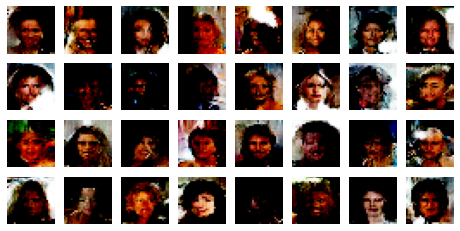

Epoch 100/500


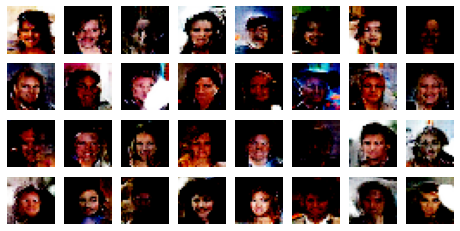

Epoch 150/500


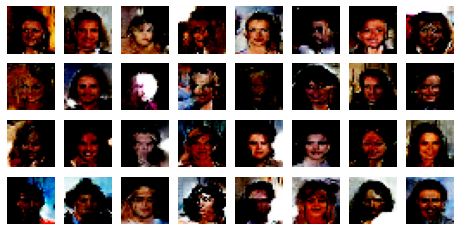

Epoch 200/500


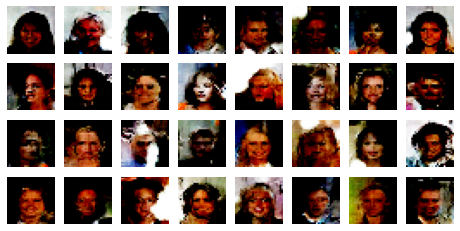

Epoch 250/500


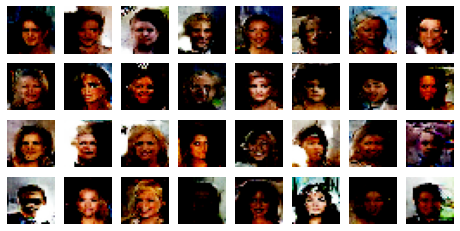

Epoch 300/500


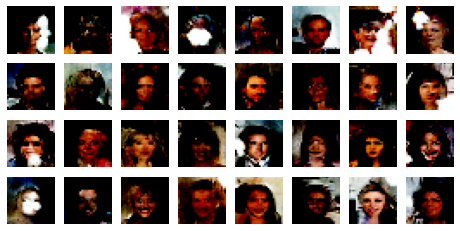

Epoch 350/500


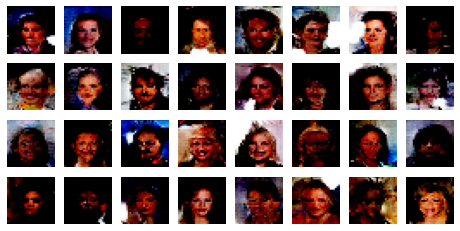

Epoch 400/500


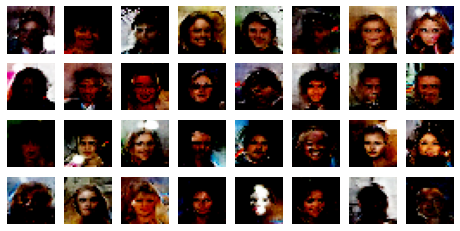

Epoch 450/500


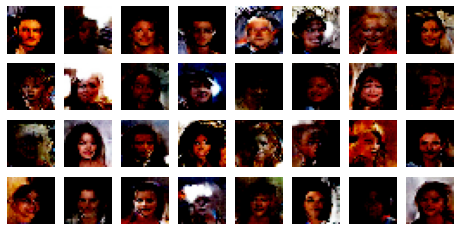

Epoch 500/500


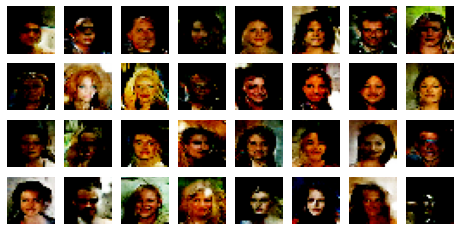

In [14]:
# training GAN (with intermidate generation of images)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=500)

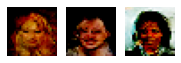

In [64]:
# Saving and plotting 3 images
noise = np.random.normal(size=(3, 100))
generated_images = generator.predict(noise)
f, ax = plt.subplots(1,3, figsize=(3,3))
for i, img in enumerate(generated_images):
        img=np.clip(img, 0, 1)
        mpimg.imsave("fake_image"+str(i)+".png", img)
        ax[i%3].imshow(img)
        ax[i%3].axis('off')
plt.show()